In [1]:
import numpy as np
import obspy
from hydrophone_data_processing import load, useful_variables, plotting, signal_processing
import scipy.signal as signal
import pandas as pd
import matplotlib.dates as dates
import obspy.signal.trigger as trigger
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import config

def import_data(day, starttime, endtime):
    daypaths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=day)
    starttime = obspy.UTCDateTime(starttime)
    endtime = obspy.UTCDateTime(endtime)
    data = load.import_corrected_data_for_single_day(daypaths)
    data.trim(starttime=starttime, endtime=endtime)
    return data

In [2]:
day141 = import_data(day=141, starttime='2019-05-21T07:00:00.0Z', endtime='2019-05-21T09:00:00.0Z')

In [3]:
day188 = import_data(day=188, starttime='2019-07-07T08:40:00.0Z', endtime='2019-07-07T10:15:00.0Z')

In [4]:
day197 = import_data(day=197, starttime='2019-07-16T21:45:00.0Z', endtime='2019-07-17T00:00:00.337999Z')

In [5]:
day211 = import_data(day=211, starttime='2019-07-30T22:30:05.142999Z', endtime='2019-07-30T23:07:04.430999Z')

In [6]:
day141[0].stats

         network: 7F
         station: A00
        location: 01
         channel: GDH
       starttime: 2019-05-21T07:00:00.000000Z
         endtime: 2019-05-21T09:00:00.000000Z
   sampling_rate: 1000.0
           delta: 0.001
            npts: 7200001
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 14851, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 60829696})
      processing: ['ObsPy 1.3.0: trim(endtime=UTCDateTime(2019, 5, 21, 9, 0)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2019, 5, 21, 7, 0))']

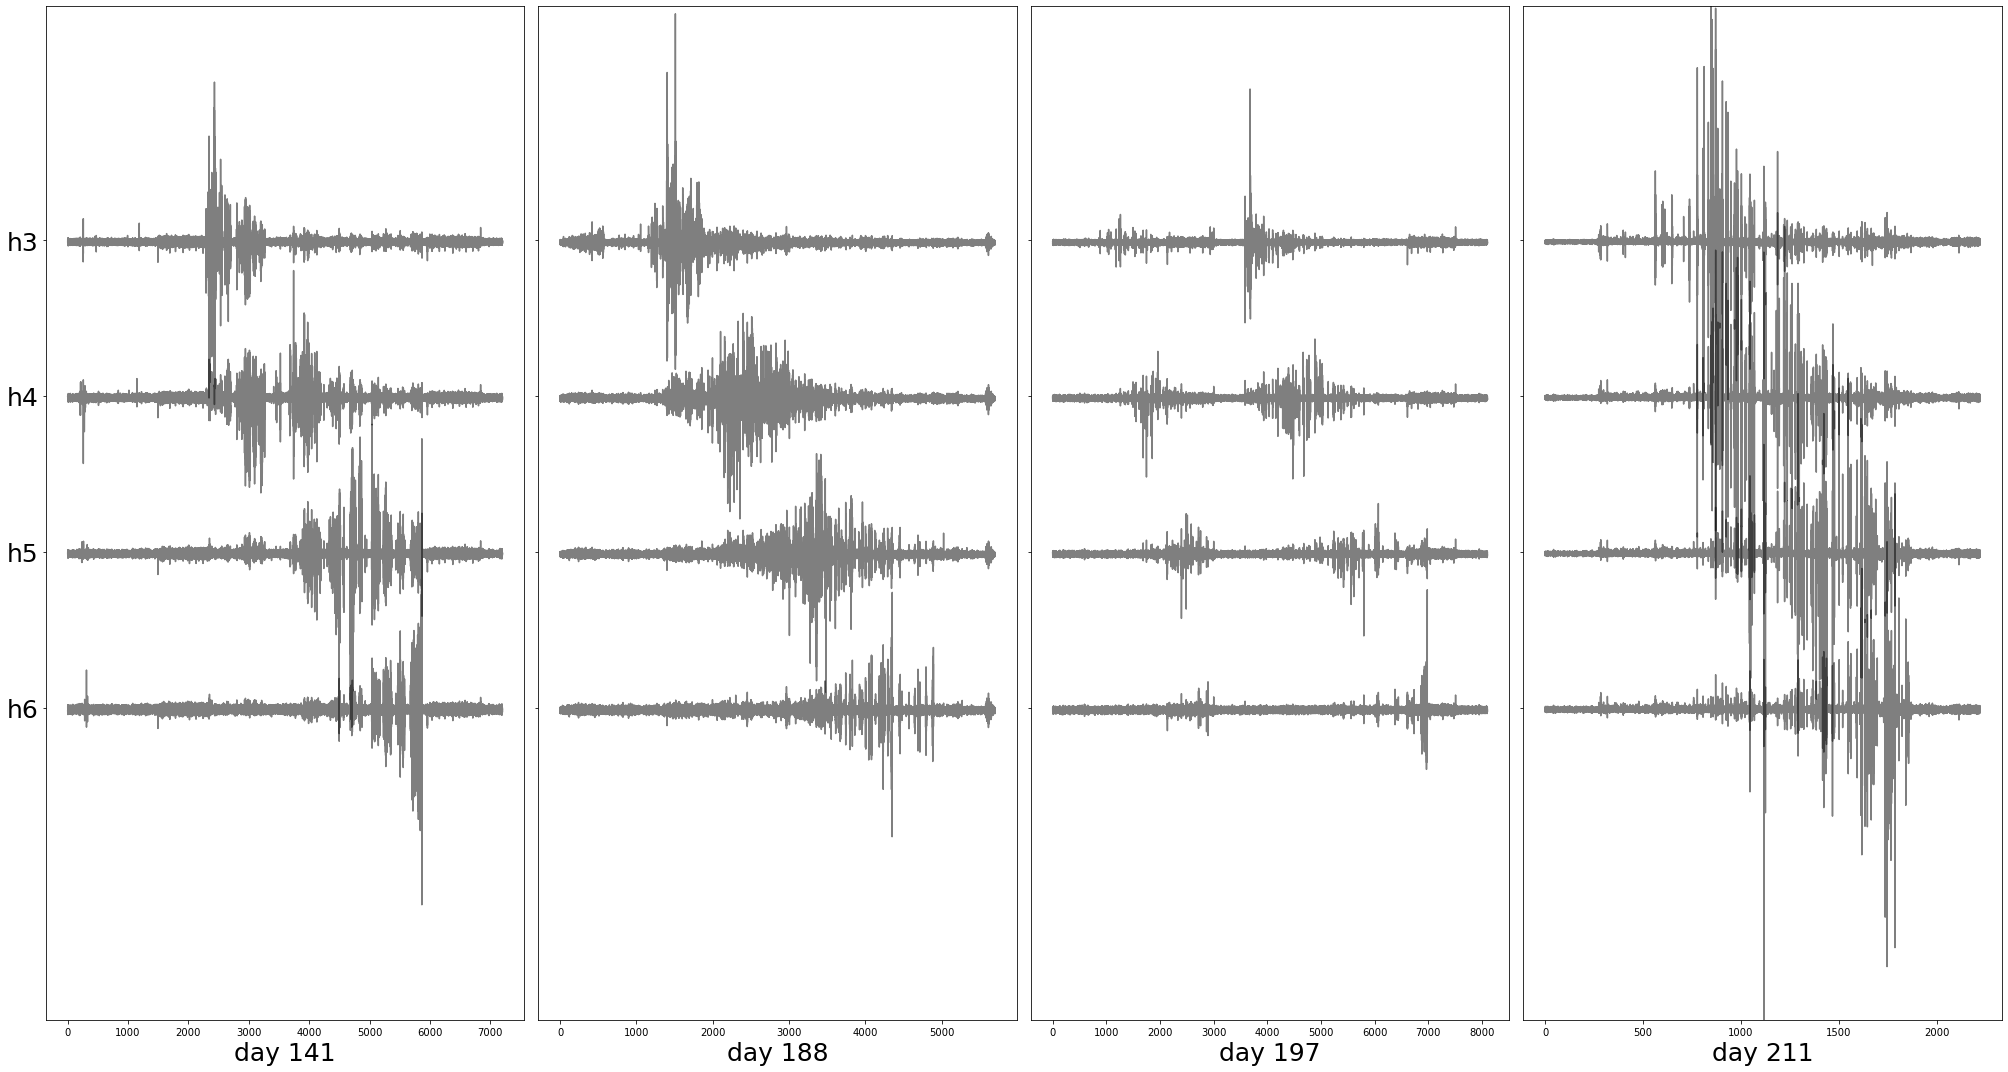

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(7*4, 15), sharey=True)

def plot_waveform(ax, stream, day):
    times = [tr.times() for tr in stream][2:]
    data = [tr.data for tr in stream][2:]
    n = 0
    for t, d in zip(times, data):
        ax.plot(t, d - n * 10, color='black', alpha=0.5)
        n+=1
        
    ax.set_xlabel('day ' + str(day), fontsize=25)

plot_waveform(ax=ax[0], stream=day141, day=141)
plot_waveform(ax=ax[1], stream=day188, day=188)
plot_waveform(ax=ax[2], stream=day197, day=197)
plot_waveform(ax=ax[3], stream=day211, day=211)

ax[0].set_ylim(-50, 15)
ax[0].set_yticks([0, -10, -20, -30])
ax[0].set_yticklabels(['h3', 'h4', 'h5', 'h6'], fontsize=25)

plt.tight_layout()

fig.savefig('figures/raw_waveforms.pdf', bbox_inches='tight')

In [8]:
import matplotlib.dates as dates

def import_catalog(file):
    df = pd.read_csv(file)
    df.sort_values(by='first_arrival', inplace=True)
    df['arrival_datetime'] = df.arrival_time.apply(dates.num2date)
    return df

def plot_depths(df, cmap, day):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.scatter(df.arrival_datetime, df.depth, marker='.', linewidth=0, c=df.first_hydrophone, cmap=cmap)
    ax.set_ylabel('day '+str(day), fontsize=25)
    ax.set_ylim(400, 50)
    # ax.text(s='N_events={}'.format(df.shape[0]), x=df.arrival_time[50], y=375, fontsize=25)
    return fig, ax

def plot_radius(df, cmap, day):
    x = df.first_arrival.values
    y = np.abs(df.radius.values)
    c = df.depth.values
    
    fig, ax = plt.subplots(figsize=(15, 5))
    cbar = ax.scatter(x, y, marker='.', c=c, vmin=150, vmax=400, cmap=cmap)
    ax.set_xticks([])
    ax.set_ylim(-10, 60)
    fig.colorbar(cbar, label='depth (m)')
    ax.set_xlabel('time ---->', fontsize=15)
    ax.set_ylabel('radius (m)', fontsize=15)
    return fig, ax

In [9]:
df141 = import_catalog(file='141precision.csv')
df188 = import_catalog(file='188precision.csv')
df197 = import_catalog(file='197precision.csv')
df211 = import_catalog(file='211precision.csv')

number of raw events: 325
number of events after max amplitude removal: 260
fraction removed: 0.19999999999999996


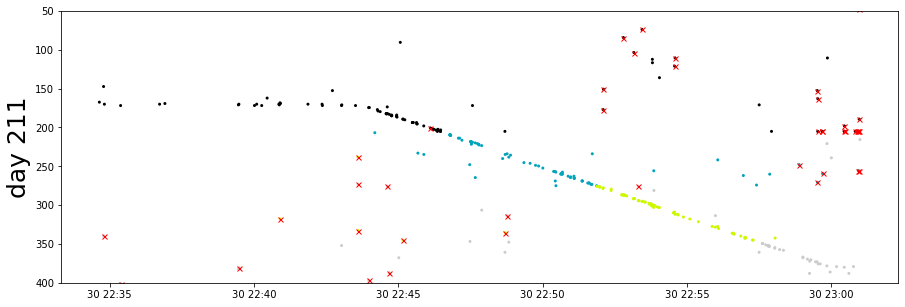

In [10]:
# The detection algorithm doesn't work for events with maximum amplitude <0.1, therefore it is likely these events are false positives and need to be removed. This can be demonstrated below.

data = df211.copy()
data_filter = data[data.max_amp > 0.1].copy()
filtered_events = data.drop(data_filter.index)

fig, ax = plot_depths(data, cmap='nipy_spectral', day=211)
ax.plot(filtered_events.arrival_datetime, filtered_events.depth, marker='x', color='red', markersize=5, linewidth=0)
print('number of raw events:', data.shape[0])
print('number of events after max amplitude removal:', data_filter.shape[0])
print('fraction removed: {}'.format(1-data_filter.shape[0]/data.shape[0]))

In [11]:
# also need to remove a number of columns that are simply irrelevant to the analysis or untested for a shareable dataset.

columns_to_keep = ['id', 'depth', 'relative_depth',
        'first_hydrophone', 'second_hydrophone',
       'arrival_time', 'first_arrival', 'second_arrival', 'dt',
       'max_amp', 'cum_amp', 'arrival_datetime']

df141 = df141[columns_to_keep].copy()
df188 = df188[columns_to_keep].copy()
df197 = df197[columns_to_keep].copy()
df211 = df211[columns_to_keep].copy()

df141.sort_values(by='arrival_datetime', inplace=True)
df188.sort_values(by='arrival_datetime', inplace=True)
df197.sort_values(by='arrival_datetime', inplace=True)
df211.sort_values(by='arrival_datetime', inplace=True)

# # removing the events with maximum amplitude <0.1 since they are false positives
df141 = df141[df141.max_amp > 0.1].copy()
df188 = df188[df188.max_amp > 0.1].copy()
df197 = df197[df197.max_amp > 0.1].copy()
df211 = df211[df211.max_amp > 0.1].copy()

# df141.drop_duplicates(subset=columns_to_keep[1:], inplace=True)
# df188.drop_duplicates(subset=columns_to_keep[1:], inplace=True)
# df197.drop_duplicates(subset=columns_to_keep[1:], inplace=True)
# df211.drop_duplicates(subset=columns_to_keep[1:], inplace=True)

df141.drop_duplicates(subset=['arrival_datetime',], inplace=True)
df188.drop_duplicates(subset=['arrival_datetime',], inplace=True)
df197.drop_duplicates(subset=['arrival_datetime',], inplace=True)
df211.drop_duplicates(subset=['arrival_datetime',], inplace=True)

In [12]:
print('day141 N-events:', df141.shape)
print('day188 N-events:', df188.shape)
print('day197 N-events:', df197.shape)
print('day211 N-events:', df211.shape)

day141 N-events: (1931, 12)
day188 N-events: (1658, 12)
day197 N-events: (593, 12)
day211 N-events: (260, 12)


In [13]:
def get_swarm_time_length(df):
    start = df.head(1).arrival_datetime.values
    end = df.tail(1).arrival_datetime.values
    tl = (end - start)/np.timedelta64(1, 's')
    return tl[0]
print('Day 141 event length:', get_swarm_time_length(df141))
print('Day 188 event length:', get_swarm_time_length(df188))
print('Day 197 event length:', get_swarm_time_length(df197))
print('Day 211 event length:', get_swarm_time_length(df211))

# (df141.tail(1).arrival_datetime.values - df141.head(1).arrival_datetime.values)/np.timedelta64(1, 's')
# get_swarm_time_length(df141)

Day 141 event length: 3545.596
Day 188 event length: 4591.384
Day 197 event length: 6621.809999
Day 211 event length: 1581.176


In [14]:
def plot_event(event_id, day_number, df):
    from event_pipeline import Event
    paths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=day_number)
    waveforms = load.import_corrected_data_for_single_day(paths=paths)
    df = df.copy()
    e = Event(id=event_id, starttime=df.arrival_time.loc[event_id], init_first_hphone=df.first_hydrophone, waveforms=waveforms)
    print('loaded event {} successfully.'.format(event_id))
    
    fig, (ax, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

    t_labels = e.stream[4].times() * 1e3 # milliseconds
    times = e.stream[4].times('matplotlib')

    ax.plot(times, e.stream[4].data, color='black', alpha=0.5)

    st = e.stream.copy()
    st.filter(type='highpass', freq=50)
    ax.plot(times, st[4].data, color='violet', label='50Hz highpass', linewidth=2)

    ax.vlines(x=e.aic_t[4], ymin=-0.9, ymax=0.7, color='cyan', linewidth=3, label='AIC pick')
    ax.set_ylim(-0.9, 0.7)
    ax.legend(fontsize=15)
    ax.set_ylabel('Pressure (Pa)', fontsize=15)
    ax.text(s='Day {dn} Event ID:{eid}'.format(dn=day_number, eid=event_id), fontsize=15, x=times[0], y=0.55)

    ax2.plot(times, e.aics[4], color='cyan', linewidth=2.5)

    ax2.set_xticks(times[::50])
    ax2.set_xticklabels(t_labels[::50])
    ax2.set_xlabel('Time (ms)', fontsize=15)
    ax2.set_ylabel('AIC', fontsize=15, color='cyan')

    ax3 = ax2.twinx()
    ax3.plot(times[1:], np.diff(e.aics[4]), color='magenta')
    ax3.set_ylabel('diff(AIC)', fontsize=15, color='magenta')

    fig.tight_layout()


/home/john/research/borehole_proj2/event_pipeline.py:197: RuntimeWarning: invalid value encountered in sqrt
  self.radius =  np.sqrt(vrock**2 * dt**2 - dz**2)


loaded event 1058 successfully.


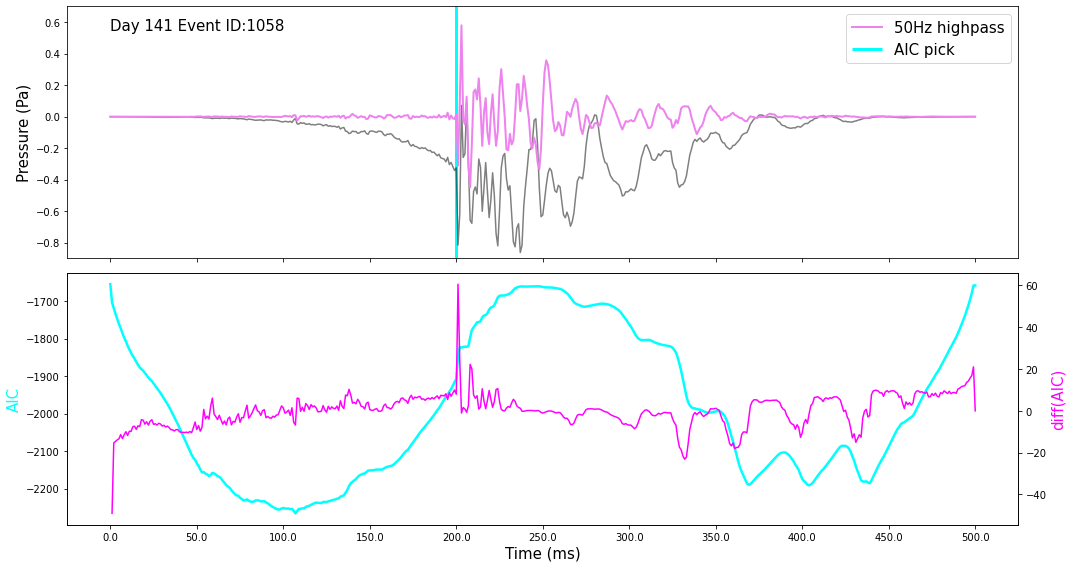

In [15]:
plot_event(event_id=1058, day_number=141, df=df141)
# df141[900:910]

loaded event 1634 successfully.


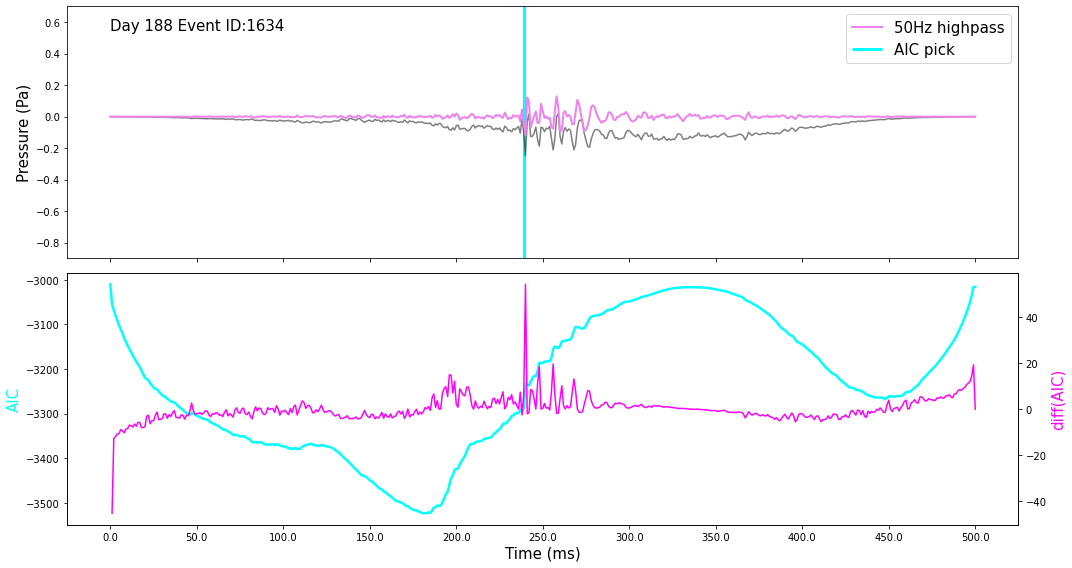

In [16]:
plot_event(event_id=1634, day_number=188, df=df188)
# df188[800:810]

loaded event 674 successfully.


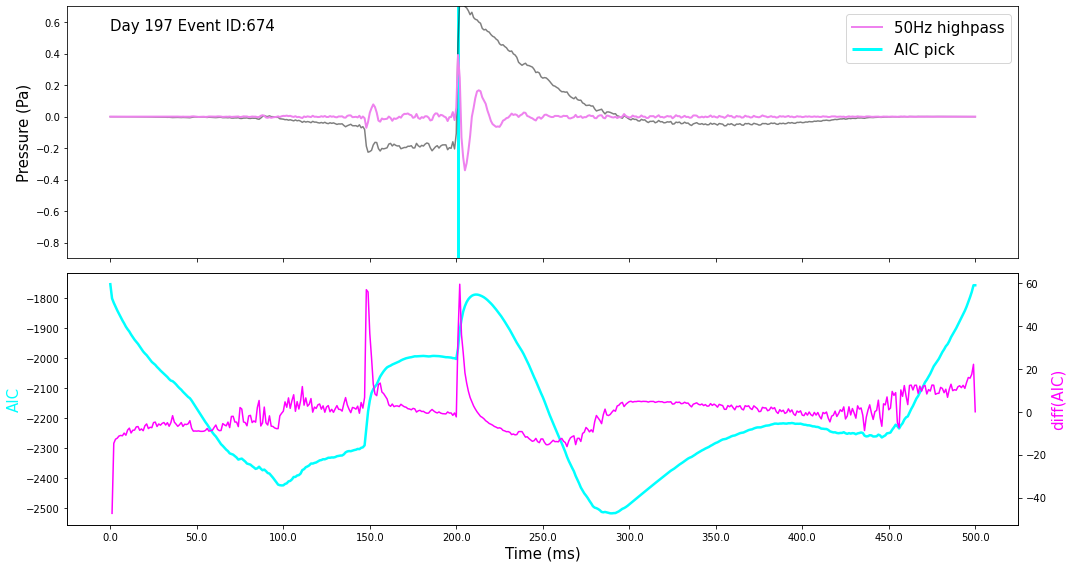

In [17]:
plot_event(event_id=674, day_number=197, df=df197)

In [18]:
# fig, ax = plt.subplots(1, 4, figsize=(5*4, 15), sharey=True, sharex=True)

# def plot_hist_scatter(day, ax=ax):
#     def plot_hydrophone_depth_horizontal_line(hid):
#         depth = config.hydrophone_metadata_141[hid]['depth']
#         ax.hlines(y=depth, xmin=0, xmax=70, linestyle='--', color='black')

#     ev_d = day.sort_values(by='depth')[['depth']].copy()
#     ax.hist(ev_d, bins=np.linspace(150, 400, (400-150)//2), orientation='horizontal', zorder=0, color='black', alpha=0.15)
#     ax2 = ax.twiny()
#     ax2.scatter(x=day['arrival_datetime'], y=day['depth'], c=day['depth']
#            ,cmap='nipy_spectral', vmin=150, vmax=400)
#     plot_hydrophone_depth_horizontal_line('h3')
#     plot_hydrophone_depth_horizontal_line('h4')
#     plot_hydrophone_depth_horizontal_line('h5')
#     plot_hydrophone_depth_horizontal_line('h6')
    
# plot_hist_scatter(day=df141, ax=ax[0])
# plot_hist_scatter(day=df188, ax=ax[1])
# plot_hist_scatter(day=df197, ax=ax[2])
# plot_hist_scatter(day=df211, ax=ax[3])

# ax[0].set_ylim(400, 150)
# ax[0].set_xlim(0, 70)
# fig.tight_layout()

# fig.savefig('figures/events.pdf', bbox_inches='tight')

Text(0, 0.5, 'Event Count')

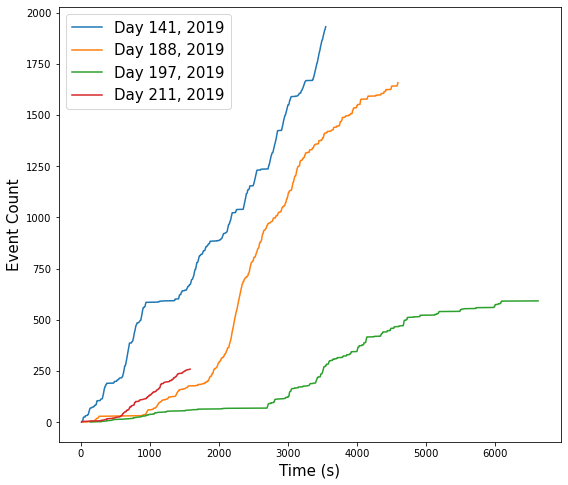

In [19]:
fig, ax = plt.subplots(figsize=(9, 8))
def make_cumcurve(df, label):
    data = df[['arrival_datetime']].copy()
    data['dt'] = data['arrival_datetime'].diff().apply(lambda t: t.total_seconds()).cumsum()
    # data['dt'] = data['dt']/data['dt'].max()
    data['ones'] = 1
    data['ones'] = data['ones'].cumsum()
    # data['ones'] = data['ones']/data['ones'].max()
    # data.set_index('dt', inplace=True)
    # ax.plot(data['dt']/data['dt'].max(), data.ones, label=label)
    ax.plot(data['dt'], data.ones, label=label)

make_cumcurve(df141, label='Day 141, 2019')
make_cumcurve(df188, label='Day 188, 2019')
make_cumcurve(df197, label='Day 197, 2019')
make_cumcurve(df211, label='Day 211, 2019')
ax.legend(fontsize=15)
ax.set_xlabel('Time (s)', fontsize=15)
ax.set_ylabel('Event Count', fontsize=15)

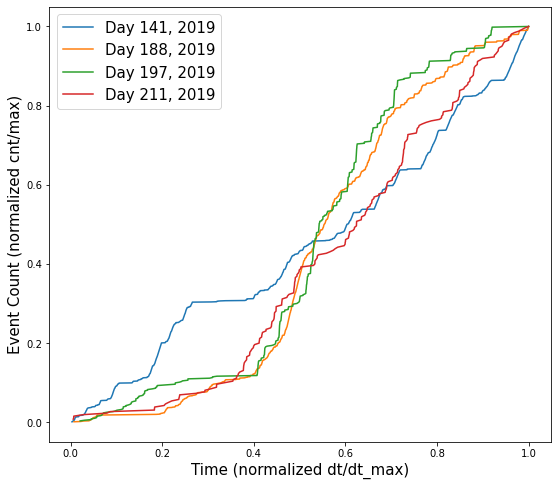

In [20]:
fig, ax = plt.subplots(figsize=(9, 8))
def make_cumcurve(df, label):
    data = df[['arrival_datetime']].copy()
    data.sort_values(by='arrival_datetime', inplace=True)
    data['dt'] = data['arrival_datetime'].diff().apply(lambda t: t.total_seconds()).cumsum()
    # data['dt'] = data['dt']/data['dt'].max()
    data['ones'] = 1
    data['ones'] = data['ones'].cumsum()
    data['ones'] = data['ones']/data['ones'].max()
    # data.set_index('dt', inplace=True)
    ax.plot(data['dt']/data['dt'].max(), data.ones, label=label)

make_cumcurve(df141, label='Day 141, 2019')
make_cumcurve(df188, label='Day 188, 2019')
make_cumcurve(df197, label='Day 197, 2019')
make_cumcurve(df211, label='Day 211, 2019')
ax.legend(fontsize=15)
ax.set_xlabel('Time (normalized dt/dt_max)', fontsize=15)
ax.set_ylabel('Event Count (normalized cnt/max)', fontsize=15)

fig.savefig('figures/event_cdf.pdf', bbox_inches='tight')

In [21]:
n = 3

def get_he(df):
    # h, e = np.histogram(df.depth.values, bins=np.linspace(150, 400, (400 - 150)//3))
    h, e = np.histogram(df.depth.values, bins=np.linspace(150, 400, (400 - 150)//n))
    h = h/h.sum() * 100
    return h, e

def get_sum(df):
    return df.sort_values(by='depth').rolling(n).sum()[n-1::n]

# fig, ax = plt.subplots(figsize=(15, 5))

depth_df = pd.DataFrame(
    {
        'day141_n': get_he(df141)[0]
        ,'day188_n':get_he(df188)[0]
        ,'day197_n':get_he(df197)[0]
        ,'day211_n':get_he(df211)[0]
        # ,'day141_ma':get_sum(df141)['max_amp'].values
    }
    # ,index = get_he(df141)[1][:-1]
)
# depth_df.corr()
get_sum(df141)
depth_df.corr()


,day141_n,day188_n,day197_n,day211_n
day141_n,1.000000,0.047599,0.151120,0.367679
day188_n,0.047599,1.000000,0.350178,0.136290
day197_n,0.151120,0.350178,1.000000,0.377872
day211_n,0.367679,0.136290,0.377872,1.000000


In [22]:
# fig, ax = plot_depths(df=df141, cmap='cool', day=141)
# fig.savefig('figures/day141_depths.pdf', bbox_inches='tight')

# fig, ax = plot_depths(df=df188, cmap='winter', day=188)
# fig.savefig('figures/day188_depths.pdf', bbox_inches='tight')

# fig, ax = plot_depths(df=df197, cmap='spring', day=197)
# fig.savefig('figures/day197_depths.pdf', bbox_inches='tight')

# fig, ax = plot_depths(df=df211, cmap='summer', day=211)
# fig.savefig('figures/day211_depths.pdf', bbox_inches='tight')


In [23]:
def remove_data_using_linear_model(X, y, removal_factor):
    
    model = LinearRegression().fit(X, y)
    predictions = model.predict(X)
    
    removal_index = np.hstack(
        (np.where(y > predictions + removal_factor*np.std(predictions))
        ,np.where(y < predictions - removal_factor*np.std(predictions)))
    )
    X_new = np.delete(X, removal_index)
    y_new = np.delete(y, removal_index)
    
    return X_new, y_new, model

def convert_matplotlib_numtimes_to_seconds_from_start(times):
    start = dates.num2date(times.min())
    end = dates.num2date(times.max())
    total_seconds = (end - start).total_seconds()

    seconds = np.array([(end - dates.num2date(t[0])).total_seconds() for t in times])
    return total_seconds - seconds

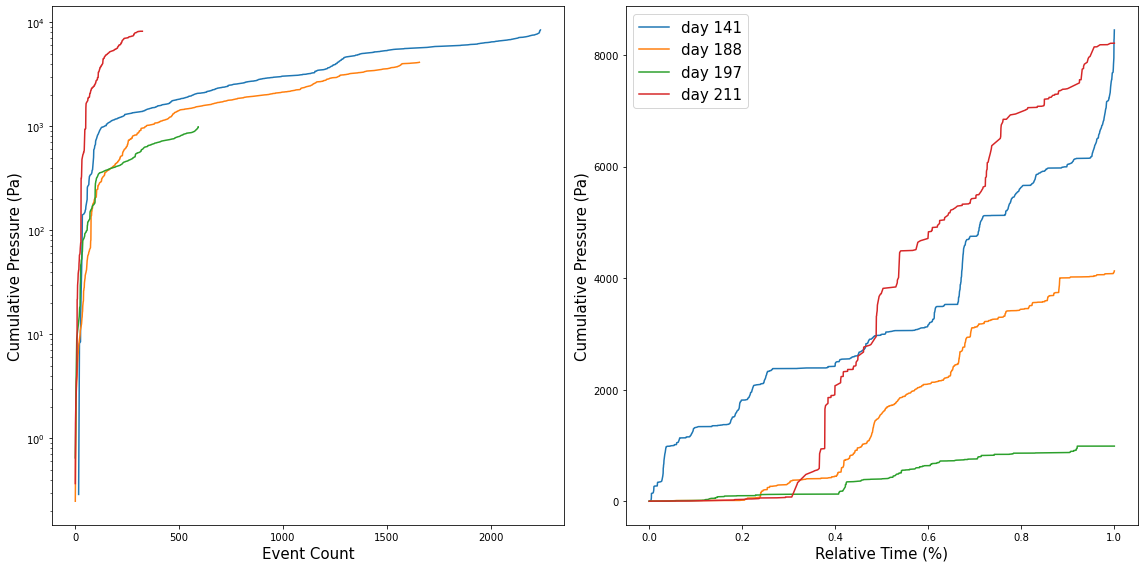

In [24]:

def make_max_amp(df):
    ma_df = pd.DataFrame(
        {
        'sec':df['arrival_datetime'].diff().apply(lambda t: t.total_seconds()).fillna(0).cumsum()
        ,'amplitude':df['max_amp']
    }
    )
    return ma_df

ma141 = make_max_amp(df141)
ma188 = make_max_amp(df188)
ma197 = make_max_amp(df197)
ma211 = make_max_amp(df211)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[1].plot(ma141['sec']/ma141['sec'].max(), ma141['amplitude'].cumsum(), label='day 141')
ax[1].plot(ma188['sec']/ma188['sec'].max(), ma188['amplitude'].cumsum(), label='day 188')
ax[1].plot(ma197['sec']/ma197['sec'].max(), ma197['amplitude'].cumsum(), label='day 197')
ax[1].plot(ma211['sec']/ma211['sec'].max(), ma211['amplitude'].cumsum(), label='day 211')
ax[1].legend(fontsize=15)
ax[1].set_ylabel(r'Cumulative Pressure (Pa)', fontsize=15)
ax[1].set_xlabel('Relative Time (%)', fontsize=15)

# fig, ax = plt.subplots(figsize=(6, 5))
df141.max_amp.cumsum().plot(ax=ax[0])
df188.sort_values(by='arrival_datetime').reset_index().max_amp.cumsum().plot(ax=ax[0])
df197.sort_values(by='arrival_datetime').reset_index().max_amp.cumsum().plot(ax=ax[0])
df211.max_amp.cumsum().plot(ax=ax[0])
ax[0].set_ylabel(r'Cumulative Pressure (Pa)', fontsize=15)
ax[0].set_xlabel('Event Count', fontsize=15)
ax[0].set_yscale('log')
fig.tight_layout()

fig.savefig('figures/energy.pdf', bbox_inches='tight')

In [25]:
def do(df):

    y = df.depth.values
    X = (df.arrival_time).values.reshape(-1, 1)
    X = convert_matplotlib_numtimes_to_seconds_from_start(X)
    X = np.vstack(X)

    fig, ax = plt.subplots(figsize=(15, 5))
    ax.set_ylim(700, -300)

    ax.scatter(X, y, marker='.', color='black')

    xnew = X
    ynew = y
    iteration = 0
    removal_factor = 5
    while True:
        xold = xnew.reshape(-1, 1)
        yold = ynew
        if 'r2' not in locals():
            r2 = -9999
            r2_old = r2
        else:
            r2_old = r2
        xnew, ynew, mod = remove_data_using_linear_model(X=xold, y=yold, removal_factor=removal_factor)
        pred = mod.predict(xold)
        r2 = r2_score(yold, pred)
        print('iteration:', iteration , '|'
              , 'R2 score:', np.round(r2, 6), '+/-', removal_factor, '*', np.std(pred), '|'
              , 'removed N=', yold.shape[0] - ynew.shape[0], '|'
              , 'velocity (m/s):', mod.coef_, '|'
              , 'starting depth:', mod.intercept_
             )
        ########
        # plotting nonsense
        color = plt.cm.jet(iteration/7.5)
        ax.scatter(xnew, ynew, marker='.', color=color)
        xline = np.linspace(X.min(), X.max(), 1000)
        yline = mod.predict(xline.reshape(-1, 1))
        ax.plot(xline, yline, color=color)
        #
        ########

        iteration += 1
        if r2 > 0.8:
            break
        # elif r2_old == r2:
        elif np.isclose(r2_old, r2, rtol=1e-6):
            removal_factor = removal_factor - 1.0
        elif iteration == 1000:
            break
        else:
            pass

    # ax.plot(xline, yline, color='red')
    ax.legend(np.arange(iteration), title='iteration')
    return mod.coef_, mod.intercept_

iteration: 0 | R2 score: 0.956161 +/- 5 * 64.64479825935891 | removed N= 0 | velocity (m/s): [0.05952873] | starting depth: 165.92633194004526


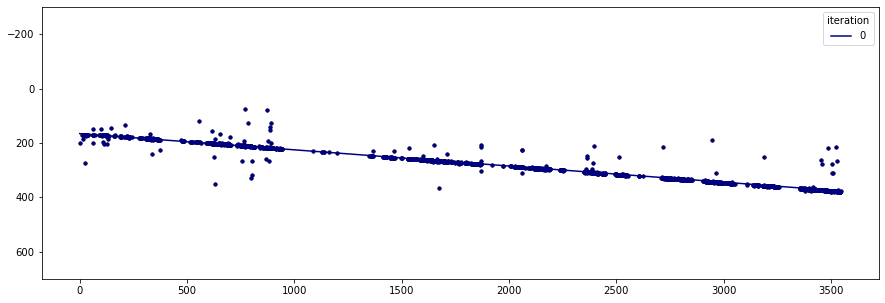

In [26]:
v141, s141 = do(df=df141)

iteration: 0 | R2 score: 0.797083 +/- 5 * 52.96864755694046 | removed N= 0 | velocity (m/s): [0.06100201] | starting depth: 109.20672367625579
iteration: 1 | R2 score: 0.797083 +/- 5 * 52.96864755694046 | removed N= 0 | velocity (m/s): [0.06100201] | starting depth: 109.20672367625579
iteration: 2 | R2 score: 0.797083 +/- 4.0 * 52.96864755694046 | removed N= 0 | velocity (m/s): [0.06100201] | starting depth: 109.20672367625579
iteration: 3 | R2 score: 0.797083 +/- 3.0 * 52.96864755694046 | removed N= 2 | velocity (m/s): [0.06100201] | starting depth: 109.20672367625579
iteration: 4 | R2 score: 0.806433 +/- 2.0 * 53.038052288043964 | removed N= 13 | velocity (m/s): [0.06110134] | starting depth: 109.16557530931809


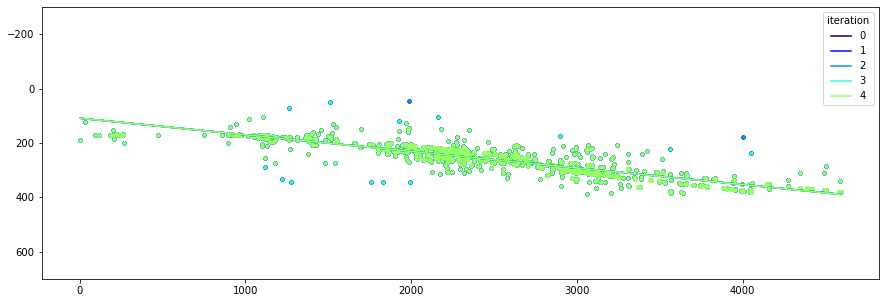

In [27]:
v188, s188 = do(df=df188[df188.depth.between(0, 400)])


iteration: 0 | R2 score: 0.431418 +/- 5 * 29.711538251320828 | removed N= 0 | velocity (m/s): [0.06204791] | starting depth: 168.32063096899253
iteration: 1 | R2 score: 0.431418 +/- 5 * 29.711538251320828 | removed N= 0 | velocity (m/s): [0.06204791] | starting depth: 168.32063096899253
iteration: 2 | R2 score: 0.431418 +/- 4.0 * 29.711538251320828 | removed N= 2 | velocity (m/s): [0.06204791] | starting depth: 168.32063096899253
iteration: 3 | R2 score: 0.685948 +/- 3.0 * 37.04031006012369 | removed N= 1 | velocity (m/s): [0.0826591] | starting depth: 152.55747253598048
iteration: 4 | R2 score: 0.811498 +/- 3.0 * 40.48930158584877 | removed N= 0 | velocity (m/s): [0.09468901] | starting depth: 143.23676040980257
iteration: 0 | R2 score: 0.872309 +/- 5 * 50.775106412940985 | removed N= 0 | velocity (m/s): [0.05713726] | starting depth: 171.58235665383768


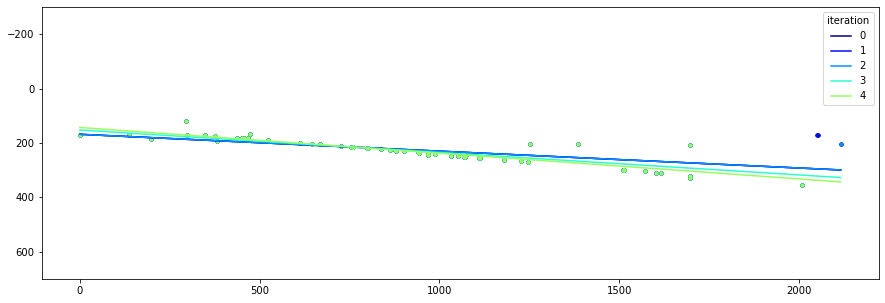

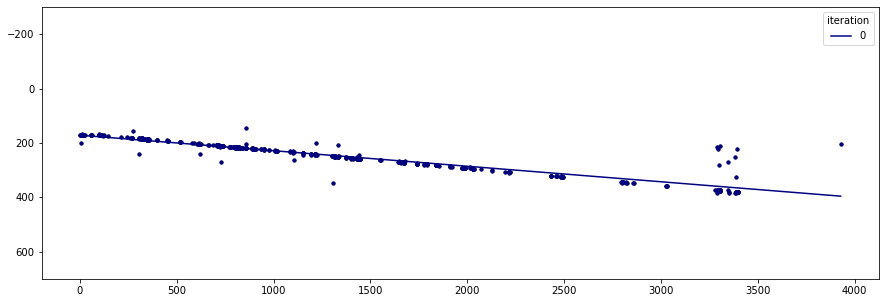

In [28]:
# plot the first event separate from second
center = 69
df1 = df197[:center]
v197a, s197a = do(df=df1[df1.depth.between(0, 400)])

df2 = df197[center:]
v197b, s197b = do(df=df2[df2.depth.between(0, 400)])

iteration: 0 | R2 score: 0.535001 +/- 5 * 45.64044375689272 | removed N= 1 | velocity (m/s): [0.16571519] | starting depth: 198.97724513600966
iteration: 1 | R2 score: 0.591832 +/- 5 * 47.33840178801068 | removed N= 0 | velocity (m/s): [0.17260727] | starting depth: 197.0299830351795
iteration: 2 | R2 score: 0.591832 +/- 5 * 47.33840178801068 | removed N= 0 | velocity (m/s): [0.17260727] | starting depth: 197.0299830351795
iteration: 3 | R2 score: 0.591832 +/- 4.0 * 47.33840178801068 | removed N= 0 | velocity (m/s): [0.17260727] | starting depth: 197.0299830351795
iteration: 4 | R2 score: 0.591832 +/- 3.0 * 47.33840178801068 | removed N= 6 | velocity (m/s): [0.17260727] | starting depth: 197.0299830351795
iteration: 5 | R2 score: 0.775841 +/- 2.0 * 51.65750338901267 | removed N= 7 | velocity (m/s): [0.18926224] | starting depth: 192.81457304120732
iteration: 6 | R2 score: 0.927726 +/- 2.0 * 54.924598194800296 | removed N= 0 | velocity (m/s): [0.20383818] | starting depth: 187.175692540

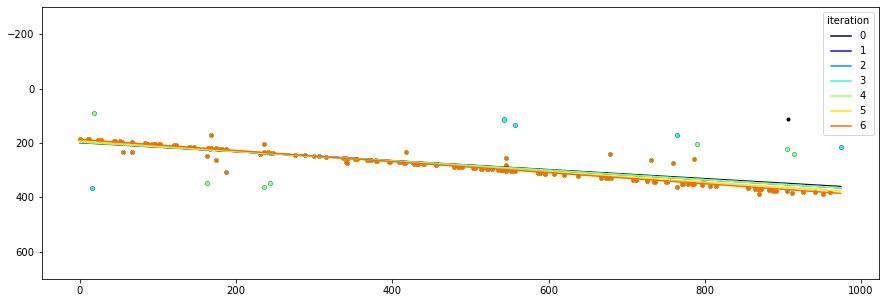

In [29]:
# remove first few events which make fitline nonlinear
df = df211[40:]
v211, s211 = do(df=df[df.depth.between(0, 400)])

In [53]:
print('day 141 velocity is:', v141)
print('day 188 velocity is:', v188)
print('day 197a velocity is:', v197a)
print('day 197b velocity is:', v197b)
print('day 211 velocity is:', v211)
print('average velocity is:', np.mean([v141, v188, v197a, v197b, v211])
     ,'+/-',np.sqrt(np.std([v141, v188, v197a, v197b, v211]))/5)

day 141 velocity is: [0.05952873]
day 188 velocity is: [0.06110134]
day 197a velocity is: [0.09468901]
day 197b velocity is: [0.05713726]
day 211 velocity is: [0.20383818]
average velocity is: 0.09525890444072518 +/- 0.04733348784974185


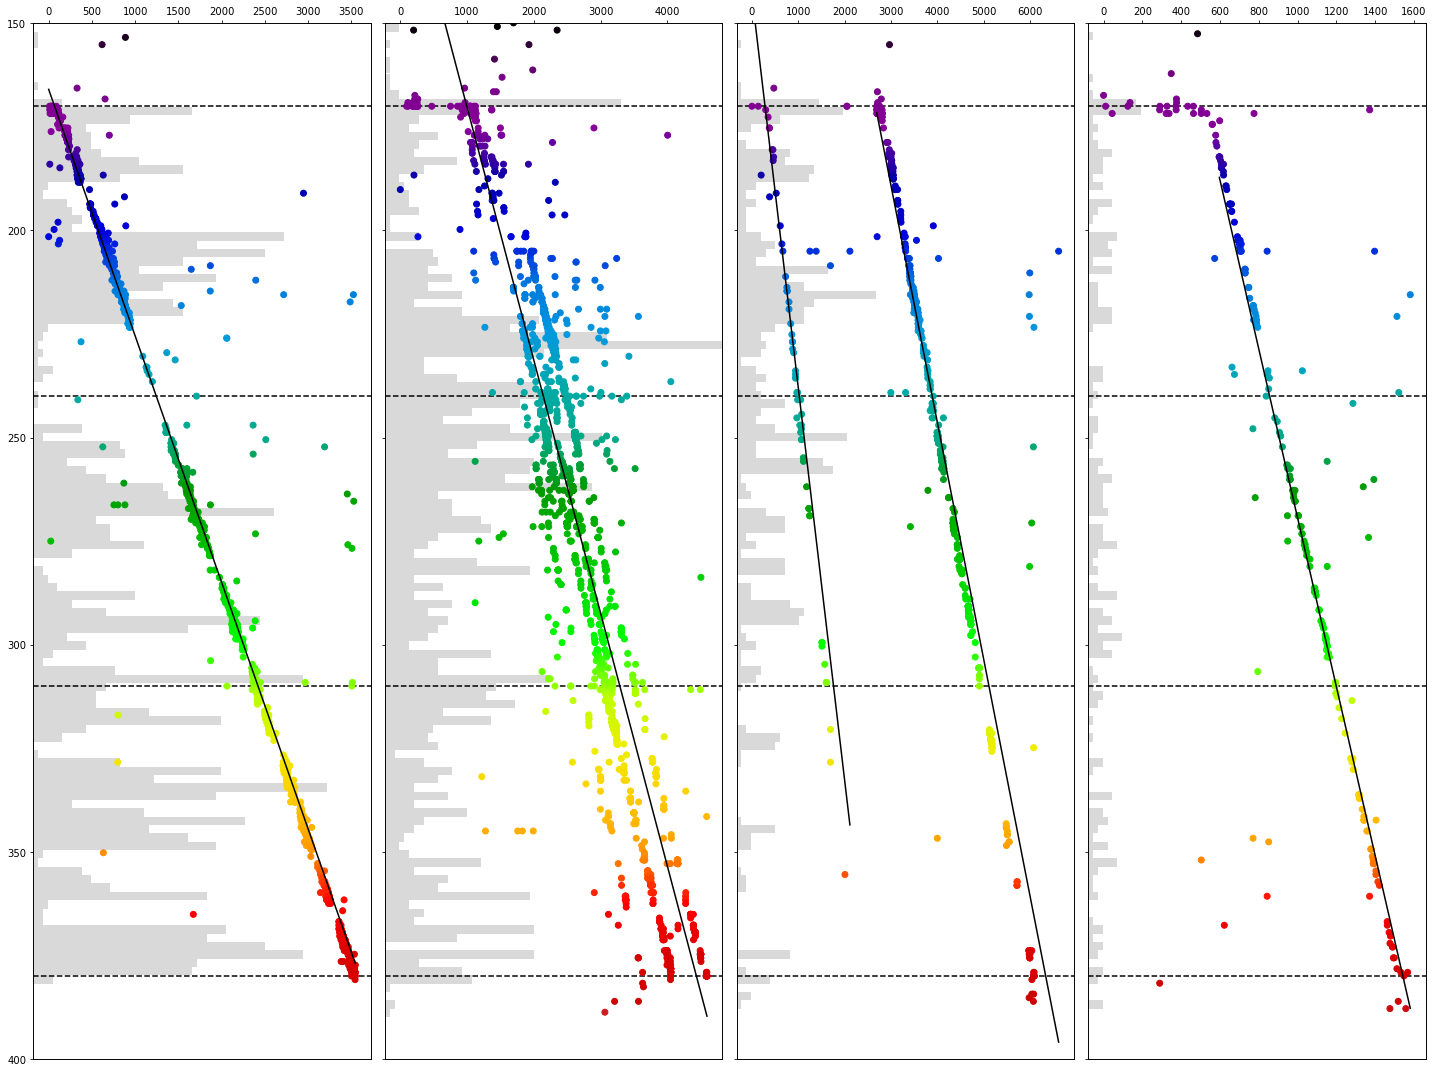

In [49]:
fig, ax = plt.subplots(1, 4, figsize=(5*4, 15), sharey=True, sharex=True)

def plot_hist_scatter(day, ax=ax):
    
    ### PLOT HISTOGRAM OF EVENTS TO SHOW DEPTH CONCENTRATIONS
    def plot_hydrophone_depth_horizontal_line(hid):
        depth = config.hydrophone_metadata_141[hid]['depth']
        ax.hlines(y=depth, xmin=0, xmax=70, linestyle='--', color='black')

    ev_d = day.sort_values(by='depth')[['depth']].copy()
    ax.hist(ev_d, bins=np.linspace(150, 400, (400-150)//2), orientation='horizontal', zorder=0, color='black', alpha=0.15)
    ax.set_xticks([])
    
    ### PLOT SCATTER PLOT OF INDIVIDUAL EVENTS TO SHOW DEPTH MIGRATIONS OVER TIME
    ax2 = ax.twiny()
    x = day['arrival_datetime'].diff().apply(lambda t: t.total_seconds()).fillna(0).cumsum().values
    y = day['depth'].values
    # ax2.scatter(x=day['arrival_datetime'], y=day['depth'], c=day['depth']
    ax2.scatter(x=x, y=day['depth'], c=day['depth']
           ,cmap='nipy_spectral', vmin=150, vmax=400)
    
    plot_hydrophone_depth_horizontal_line('h3')
    plot_hydrophone_depth_horizontal_line('h4')
    plot_hydrophone_depth_horizontal_line('h5')
    plot_hydrophone_depth_horizontal_line('h6')
    
    ### PLOT FIT LINES TO SHOW MIGRATION VELOCITIES
    def plot_migration_line(slope, intercept, x=x):
        y = slope * x + intercept
        ax2.plot(x, y, color='black')
        # print(x)
    
  
    from pandas.testing import assert_frame_equal
    try:
        assert_frame_equal(day, df141, check_dtype=False)
        plot_migration_line(v141, s141)
    except AssertionError:
        pass
    try:
        assert_frame_equal(day, df188, check_dtype=False)
        plot_migration_line(v188, s188)
    except AssertionError:
        pass
    try:
        assert_frame_equal(day, df197, check_dtype=False)
        #we need to split the data between the two events
        plot_migration_line(v197a, s197a, x=x[:69])
        # plot_migration_line(v197b, s197b, x=x[69:])
        # plot_migration_line(v197b, s197b, x=x[69:] - x[69])
        y = v197b * (x[69:] - x[69]) + s197b
        ax2.plot(x[69:], y, color='black')
    except AssertionError:
        pass
    try:
        assert_frame_equal(day, df211, check_dtype=False)
        # plot_migration_line(v211, s211, x=x[20:])
        offset = 35
        y = v211 * (x[offset:] - x[offset]) + s211
        ax2.plot(x[offset:], y, color='black')
    except AssertionError:
        pass
        
    
plot_hist_scatter(day=df141, ax=ax[0])
plot_hist_scatter(day=df188, ax=ax[1])
plot_hist_scatter(day=df197, ax=ax[2])
plot_hist_scatter(day=df211, ax=ax[3])

ax[0].set_ylim(400, 150)
ax[0].set_xlim(0, 70)
fig.tight_layout()

fig.savefig('figures/events.pdf', bbox_inches='tight')

In [31]:
# from pandas.testing import assert_frame_equal
# df1 = pd.DataFrame([2, 3, 4])
# df2 = pd.DataFrame()
# try:
#     assert_frame_equal(df1, df2, check_dtype=False)
#     print('your mom')
# except AssertionError:
#     print('didnt work bro')

<AxesSubplot:xlabel='arrival_datetime'>

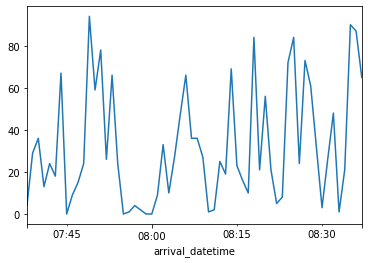

In [32]:
df141.groupby(pd.Grouper(key = 'arrival_datetime', freq='1min')).count().id.plot()

In [33]:
times = df141.arrival_datetime.diff().apply(lambda t: t.total_seconds()).values
times = times[1:].cumsum()
X = np.vstack([times
,df141.depth.values[1:]]).transpose()

array([[  10.204,  170.   ],
       [  13.384,  184.   ],
       [  13.839,  170.875],
       ...,
       [3543.79 ,  380.   ],
       [3544.744,  379.125],
       [3545.596,  377.375]])

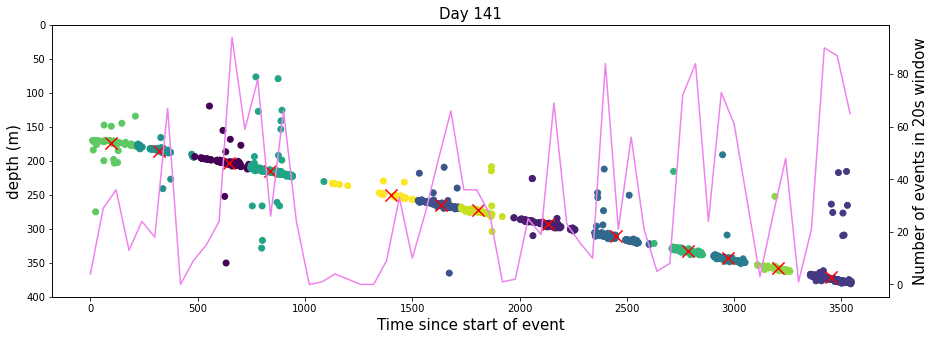

In [34]:
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt

data = df141.copy()

# Generate some random data with two variables (x and y)
# np.random.seed(42)
times = data.arrival_datetime.diff().apply(lambda t: t.total_seconds()).values
times = times[1:].cumsum()
X = np.vstack([times
,data.depth.values[1:]]).transpose()

# Fit KMeans clustering model with two clusters
kmeans = KMeans(n_clusters=13).fit(X)

# Get cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Plot data points with different colors for each cluster
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(X[:, 0], X[:, 1], c=labels)
# Plot centroids with black color and larger marker size
ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=150, color='red')
ax.set_ylim(400, 0)
kmeans.inertia_
ax.set_ylabel('depth (m)', fontsize=15)
ax.set_xlabel('Time since start of event', fontsize=15)

ax2 = ax.twinx()
window = data.groupby(pd.Grouper(key = 'arrival_datetime', freq='1min')).count().id#.plot(ax=ax2)
window_t = window.index.to_series().diff().apply(lambda t: t.total_seconds())
x = window_t.fillna(0).cumsum().values
y = window.values
ax2.plot(x, y, color='violet')
ax2.set_ylabel('Number of events in 20s window', fontsize=15)

ax.set_title('Day 141', fontsize=15)
X

In [35]:
print('mean recurrence interval:', pd.Series(sorted(centroids[:,0])).diff().mean())

mean recurrence interval: 279.4415984046786


In [36]:
def make_tn(df):
    df = df.copy().arrival_datetime.drop_duplicates()
    tn = df.values
    # time since last event
    ts = []
    # time until next event
    tu = []
    for n, t in enumerate(tn):
        # we use a try/except block to take care of the 
        # failure when looking before the array starts
        # and after the array ends
        try:
            tn_minus1 = tn[n-1]
            tn_plus1 = tn[n+1]
            ts.append(t - tn_minus1)
            tu.append(tn_plus1 - t)
        except:
            pass
    
    tndf = pd.DataFrame(
        {
            'tn-1':ts
            ,'tn':tn[1:]
            ,'tn+1':tu
        }
        ,index=df[1:].index
    )
    tndf['tn-1'] = tndf['tn-1'].apply(lambda t: t.total_seconds())
    tndf['tn+1'] = tndf['tn+1'].apply(lambda t: t.total_seconds())
    return tndf

In [37]:
df197.copy().arrival_datetime.sort_values()

0      2019-07-16 21:59:46.184000+00:00
1      2019-07-16 22:02:02.188000+00:00
4      2019-07-16 22:03:05.322000+00:00
5      2019-07-16 22:04:42.920000+00:00
6      2019-07-16 22:04:43.470000+00:00
                     ...               
920    2019-07-16 23:41:17.133999+00:00
1051   2019-07-16 23:41:18.632999+00:00
1052   2019-07-16 23:41:19.562999+00:00
1053   2019-07-16 23:41:20.301999+00:00
674    2019-07-16 23:50:07.993999+00:00
Name: arrival_datetime, Length: 593, dtype: datetime64[ns, UTC]

In [38]:
df197.loc[924]

KeyError: 924

In [ ]:
df197.loc[243] == df197.loc[924]

In [ ]:
df197.shape

In [ ]:
df197.drop_duplicates().shape

In [ ]:
tndf = pd.concat(
    [
     make_tn(df141)
    ,make_tn(df188)
    ,make_tn(df197)
    ,make_tn(df211)
    ]
)

print('number of total events:', tndf.shape)
fig, ax = plt.subplots(figsize=(9, 8))
ax.scatter(x=tndf['tn-1'], y=tndf['tn+1'], marker='.', color='red', alpha=0.15)
# ax.plot(tndf['tn-1'], tndf['tn+1'], marker='.', color='red', alpha=0.15)
# ax.plot(tndf['tn-1'], tndf['tn+1'], marker='.', cmap='nipy_spectral', c=tndf.index.values/4438, alpha=0.15)
ax.set_xlim(0.1, 2.5)
ax.set_ylim(0.1, 2.5)
ax.set_xlabel(r'$(t_{n-1})$ time since previous event (s)', fontsize=15)
ax.set_ylabel(r'$(t_{n+1})$ time until next event (s)', fontsize=15)

x = np.linspace(0, 5, 100)
y = x
ax.plot(x, y, color='dodgerblue')
y = 2*x
ax.plot(x, y, color='dodgerblue')
y = 0.5*x
ax.plot(x, y, color='dodgerblue')
print('fraction of events occuring between 0.25s and 0.75s before/after the current event:', tndf[tndf['tn-1'].between(0.25, 0.75) & tndf['tn+1'].between(0.25, 0.75)].shape[0]/tndf.shape[0])

fig.tight_layout()
fig.savefig('figures/periodicity.pdf', bbox_inches='tight')

In [ ]:
# xy = tndf[(tndf['tn-1']>0) & (tndf['tn+1']>0)][['tn-1', 'tn+1']].copy()

# fig, ax = plt.subplots(figsize=(9, 7))

# h, e1, e2, cbar = ax.hist2d(x=xy['tn-1'].values, y=xy['tn+1'].values, range=[[0, 1], [0, 1]], bins=25, cmap='Spectral_r', vmin=1)
# x = np.linspace(0, 5, 100)
# y = x
# ax.plot(x, y, color='cyan')
# y = 2*x
# ax.plot(x, y, color='cyan')
# y = 0.5*x
# ax.plot(x, y, color='cyan')

# fig.colorbar(cbar)

# ax.set_xlabel(r'$(t_{n-1})$ time since previous event (s)', fontsize=15)
# ax.set_ylabel(r'$(t_{n+1})$ time until next event (s)', fontsize=15)
# fig.tight_layout()


In [ ]:
xy = tndf[(tndf['tn-1']>0) & (tndf['tn+1']>0)][['tn-1', 'tn+1']].copy()

h, e1, e2 = np.histogram2d(x=xy['tn-1'].values, y=xy['tn+1'].values, range=[[0, 1], [0, 1]], bins=25)

print('fraction of events represented in plot:', h.sum()/tndf.shape[0])

h = h/tndf.shape[0] * 100

fig, ax = plt.subplots(figsize=(9, 7))

cbar = ax.pcolormesh(e1, e2, h, cmap='Spectral_r')
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
x = np.linspace(0, 5, 100)
y = x
ax.plot(x, y, color='darkorange', linewidth=2)
y = 2*x
ax.plot(x, y, color='darkorange', linewidth=2)
y = 0.5*x
ax.plot(x, y, color='darkorange', linewidth=2)

ax.set_xlabel(r'$(t_{n-1})$ time since previous event (s)', fontsize=15)
ax.set_ylabel(r'$(t_{n+1})$ time until next event (s)', fontsize=15)

cbar = fig.colorbar(cbar)
cbar.ax.set_ylabel('Percentage of Events', fontsize=15)
fig.savefig('figures/periodicity_zoom.pdf', bbox_inches='tight')

In [ ]:
tndf.set_index('tn')['tn+1'][:1930].plot()

In [ ]:
df188

In [ ]:
tndf['tn+1'].hist(bins=np.linspace(0, 5, 100))

In [ ]:
tndf[tndf['tn-1'].between(-0.001, 0.001)]

In [ ]:
import statsmodels.api as sm
from statsmodels.graphics import tsaplots

ts = df141.groupby(pd.Grouper(key = 'arrival_datetime', freq='10s')).count().id
ts_cnt = ts.values
ts_dt = ts.index
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.arange(1, ts_dt.shape[0]*10, 10), ts_cnt)
fig = tsaplots.plot_acf(ts_cnt, lags=100, ax=ax[1])

In [ ]:
# tndf = make_tn(df141)

# fig, ax = plt.subplots(figsize=(9, 8))
# ax.scatter(x=tndf['tn-1'], y=tndf['tn+1'], marker='.', color='red', alpha=0.5)
# # ax.set_xlim(0, 2)
# # ax.set_ylim(0, 2)
# ax.set_xlabel('time since previous event (s)', fontsize=15)
# ax.set_ylabel('time until next event (s)', fontsize=15)

In [ ]:
# tn = df141.arrival_datetime.values

# time_since_last_event = []
# time_until_next_event = []

# for n, t in enumerate(tn):
#     try:
#         # print(tn[n-1], t, tn[n+1])
#         tn_minus1 = tn[n-1]
#         tn_plus1 = tn[n+1]
#         time_since_last_event.append(t - tn_minus1)
#         time_until_next_event.append(tn_plus1 - t)
#     except:
#         pass
    
# # ax.scatter(time_since_last_event, time_until_next_event)
# tndf = pd.DataFrame({'tn-1':time_since_last_event
#               ,'t':tn[1:]
#               ,'tn+1':time_until_next_event
#              })
# tndf['tn-1'] = tndf['tn-1'].apply(lambda t: t.total_seconds())
# tndf['tn+1'] = tndf['tn+1'].apply(lambda t: t.total_seconds())

# fig, ax = plt.subplots(figsize=(9, 8))
# ax.scatter(x=tndf['tn-1'], y=tndf['tn+1'], marker='.', color='red', alpha=0.5)
# ax.set_xlim(0, 2)
# ax.set_ylim(0, 2)
# ax.set_xlabel('time since previous event (s)', fontsize=15)
# ax.set_ylabel('time until next event (s)', fontsize=15)

In [ ]:
(tndf['tn'] - tndf['tn+1']).apply(lambda t: t.total_seconds())

In [ ]:
x = np.array([1, 2, 3])
np.append(x, 4)
np.concatenate([[0], x])
np.concatenate([tn[1:], [np.datetime64('1970')]])
# np.concatn[1:]

In [ ]:
# # from sklearn.cluster import KMeans, DBSCAN
# # import matplotlib.pyplot as plt

# data = df141.copy()

# # Generate some random data with two variables (x and y)
# # np.random.seed(42)
# times = data.arrival_datetime.diff().apply(lambda t: t.total_seconds()).values
# times = times[1:].cumsum()
# X = np.vstack([times
# ,data.depth.values[1:]]).transpose()

# centroids = []
# for n in np.arange(0, 100, 1):

# # Fit KMeans clustering model with two clusters
#     kmeans = KMeans(n_clusters=13).fit(X)

# # Get cluster labels and centroids
#     labels = kmeans.labels_
#     centroid = kmeans.cluster_centers_
#     centroids.append(centroid)
    


# # # Plot data points with different colors for each cluster
# # fig, ax = plt.subplots(figsize=(15, 5))
# # ax.scatter(X[:, 0], X[:, 1], c=labels)
# # # Plot centroids with black color and larger marker size
# # ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=150, color='red')
# # ax.set_ylim(400, 0)
# # kmeans.inertia_
# # ax.set_ylabel('depth (m)', fontsize=15)
# # ax.set_xlabel('Time since start of event', fontsize=15)

# # ax2 = ax.twinx()
# # window = data.groupby(pd.Grouper(key = 'arrival_datetime', freq='1min')).count().id#.plot(ax=ax2)
# # window_t = window.index.to_series().diff().apply(lambda t: t.total_seconds())
# # x = window_t.fillna(0).cumsum().values
# # y = window.values
# # ax2.plot(x, y, color='violet')
# # ax2.set_ylabel('Number of events in 20s window', fontsize=15)

# # ax.set_title('Day 141', fontsize=15)

In [ ]:
# fig, ax = plt.subplots(figsize=(15, 5))

# for run in centroids:
#     ax.scatter(run[:,0], run[:,1], color='red', alpha=0.5)

In [ ]:
# from sklearn.cluster import KMeans, DBSCAN
# import matplotlib.pyplot as plt

# data = df141.copy()

# # Generate some random data with two variables (x and y)
# # np.random.seed(42)
# times = data.arrival_datetime.diff().apply(lambda t: t.total_seconds()).values
# times = times[1:].cumsum()

# X = np.vstack([times, data.depth.values[1:]
#               ]).transpose()

# fig, ax = plt.subplots(figsize=(5, 15))
# ax.scatter(X[:,0], X[:,1])
# ax.set_ylim(400, 150)

# # roll = pd.DataFrame(X, columns=['time', 'depth']).groupby(pd.Grouper(key = 'time', freq='1min')).count()
# # ax.plot(roll.time, roll.depth, color='red')
# y = df141.groupby(pd.Grouper(key='arrival_datetime', freq='20s')).mean().depth
# x = y.index.to_series().diff().apply(lambda t: t.total_seconds()).fillna(0).cumsum().values

# # x = y.index.to_series().diff().apply(lambda t: t.total_seconds())
# # x = np.arange(0, y.shape[0], 20)
# ax2 = ax.twinx()
# ax.ploat(x, y.values, color='red')
# y

In [ ]:
# X

In [ ]:
# df141.columns

In [ ]:
# df141['better_radius'] = np.sqrt(4500**2 * df141.dt.values**2 - df141.relative_depth.values**2)


In [ ]:
# df141.better_radius.hist(bins=100)

In [ ]:
# fig, ax = plt.subplots(figsize=(15, 5))
# cbar = df141.plot.scatter(x='first_arrival', y='better_radius', ax=ax, c='depth', cmap='cool_r', vmin=150, vmax=400)
# ax.set_xticks([])
# plot_radius(df=df141, cmap='cool', day=141)


In [ ]:
# plot_radius(df=df141, cmap='cool', day=141)
# plot_radius(df=df188, cmap='winter', day=188)
# plot_radius(df=df197, cmap='spring', day=197)
# plot_radius(df=df211, cmap='summer', day=211)

In [ ]:
# df141.plot.scatter(x='depth', y='radius')

In [ ]:
# df141.depth.hist()

In [ ]:
# df141.columns

In [ ]:
# df141[['depth', 'radius', 'first_hydrophone', 'second_hydrophone']].corr()

In [ ]:
# df141['first_arrival'] = df.first_arrival.apply(pd.to_datetime)
# df141['diff'] = df141.first_arrival.diff().apply(lambda t: t.total_seconds())

# df141['diff'].plot()

In [ ]:
# df141.depth.hist(bins=100)

In [ ]:
def make_time_interval_plots(df):
    df = df.copy().sort_values(by='first_arrival')
    
    df['first_arrival'] = df.first_arrival.apply(pd.to_datetime)
    df['diff'] = df.first_arrival.diff().apply(lambda t: t.total_seconds())
    df.set_index('first_arrival', inplace=True)
    
    fig, ax = plt.subplots()
    df['diff'].plot(ax=ax)
    
    fig, ax = plt.subplots()
    df['diff'].hist(bins=np.linspace(0, 20, 100), log=True, ax=ax)

In [ ]:
# make_time_interval_plots(df=df141)

In [ ]:
# make_time_interval_plots(df=df188)

In [ ]:
# make_time_interval_plots(df=df197)

In [ ]:
# make_time_interval_plots(df=df211)

In [ ]:
# # what if its at the borehole wall?
# import config
# config.hydrophone_metadata_141['h3']

In [ ]:
# df141.first_hydrophone.unique()

In [ ]:
phone_depths = []
for first_phone in df141.first_hydrophone.values:
    phone_id = 'h'+str(first_phone+1)
    dh = config.hydrophone_metadata_141[phone_id]['depth']
    phone_depths.append(dh)
    
df141['first_phone_depth'] = phone_depths

In [ ]:
wall_velocities = (df141.first_phone_depth - df141.depth)/(pd.to_datetime(df141.first_arrival) - pd.to_datetime(df141.parrival)).apply(lambda t: t.total_seconds())

In [ ]:
wall_velocities.replace([np.inf, -np.inf], np.nan, inplace=True)


In [ ]:
wall_velocities.abs().hist(bins=np.linspace(-2000, 2000, 100))

In [ ]:
wall_velocities.abs().hist(bins=100, log=True)

In [ ]:
wall_velocities.abs().mean()

In [ ]:
wall_velocities.abs().std()

In [ ]:
# (df141.depth/1750
# ).hist(bins=51)

In [ ]:
# (df141.depth/6800).mean()

In [ ]:
# (df141.depth/6000).hist(bins=51)

In [ ]:
# df141.iloc[750]

# velocity = 
# # [rows, cols]
# dist_from_borehole = np.zeros([240-170, 51])
# # for i in np.arange(dist_from_borehole.shape[0]):
# for row in np.arange(dist_from_borehole.shape[0]):
#     for col in np.arange(dist_from_borehole.shape[1]):
        

In [ ]:
# dist_from_borehole.shape

In [ ]:
# config.hydrophone_metadata_141['h3']

In [ ]:
# config.hydrophone_metadata_141['h4']